In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # pattern searching
import seaborn as sns # statistical plots
import matplotlib.pyplot as plt # plots
from scipy import stats
from scipy.stats import norm
import plotly.graph_objects as go
import plotly.express as px
%matplotlib inline

# **Loading the training and testing data**

In [2]:
df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# **Finding the outliers**

In [3]:
is_outlier = (df_train['GrLivArea']>4000)&(df_train['SalePrice']<700000)
# sns.scatterplot(data=df_train['total_bill'], hue=is_outlier)

#fig, ax = plt.subplots(figsize=(12,8))
#sns.scatterplot(data=df_train, x='GrLivArea', y='SalePrice',hue=is_outlier, ax=ax, legend = False);

figure = px.scatter(df_train, x='GrLivArea', y='SalePrice', color=is_outlier)
# ax.axhline(y=300000 , color='Black', dashes=(4,1,2,1))
# ax.axvline(x=4000, color='Grey', dashes=(2,1,1,1))
# ax.legend(False)
# ax.fill_between(4000, 30000,facecolor ='black', alpha = 0.8)
figure.show()

<span style="font-size:18px;"> 
    After plotting few critical parameters such as gross living area against house sales price we can see that there are some outliers which can be really difficult to accommodate in any prediction models. The best way to deal with them is to remove them from the dataset for the sake of modeling
</span>

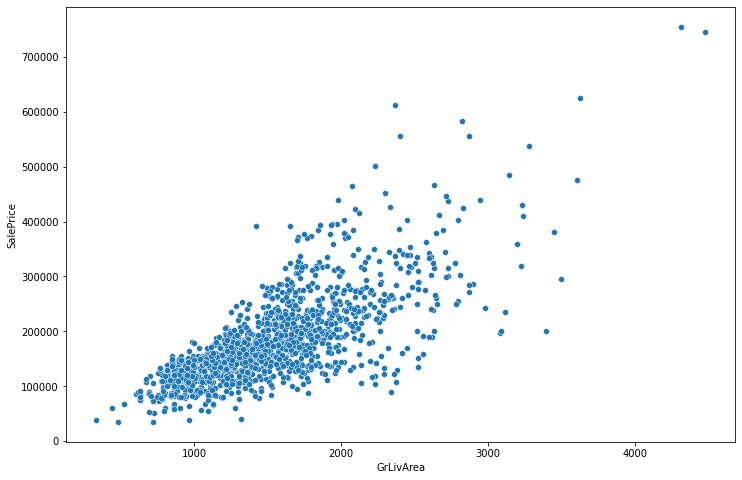

In [4]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea']>4000) 
        &    (df_train['SalePrice']<700000)].index)
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(data=df_train, x='GrLivArea', y='SalePrice', ax=ax);
# ax.axhline(y=300000 , color='Black', dashes=(4,1,2,1))
# ax.axvline(x=4000, color='Grey', dashes=(2,1,1,1))

<span style="font-size:18px;">
    After removing the outliers we created a copy of train data (except sales price) and test data and appended them to make a total feature dataset
</span>

In [5]:
train_copy = df_train.copy().drop('SalePrice', axis=1)
test_copy = df_test.copy()
df_total = pd.concat([train_copy, test_copy])
df_total.to_csv('df_total.csv')
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   int64  
 1   MSZoning       2913 non-null   object 
 2   LotFrontage    2431 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2917 non-null   object 
 7   LandContour    2917 non-null   object 
 8   Utilities      2915 non-null   object 
 9   LotConfig      2917 non-null   object 
 10  LandSlope      2917 non-null   object 
 11  Neighborhood   2917 non-null   object 
 12  Condition1     2917 non-null   object 
 13  Condition2     2917 non-null   object 
 14  BldgType       2917 non-null   object 
 15  HouseStyle     2917 non-null   object 
 16  OverallQual    2917 non-null   int64  
 17  OverallCond    2917 non-null   int64  
 18  YearBuil

<span style="font-size:18px;">
    Some features have incorrect datatypes and lot of features have missing values. Feature set needs dtype conversion and imputation before it can be used for modelling
</span>

## **Converting dtypes**

In [6]:
##converting the numerical columns into object columns
df_total['GarageYrBlt'] = df_total['GarageYrBlt'].fillna(0).astype('int64')
df_total['MSSubClass'] = df_total['MSSubClass'].astype('object')
df_total['MoSold'] = df_total['MoSold'].astype('object', copy=False)
df_total['YrSold'] = df_total['YrSold'].astype('object', copy=False)

# **Primary Imputation**

<p style="font-size:24px">
    In the first stage we will use logical assumptions to impute the missing data.
</p>

<ol style="font-size:18px; line-height:200%">
    <li>MS Zoning: We can fairly assume that Houses in the same residential zone will possibly have same housing subclass and neighborhood. Based MSSubClass and Neighborhood of the record (with missing MSZoning value), we can impute the missing value with mode value for that combination of MSSubClass and Neighborhood e.g. If MSSubClass and Neighborhood for a record with missing MSZoning value are 150 and North Ames we find the mode MSZoning value for all the records with 150 MSSubClass and North Ames Neighborhood which lets assume is Residential Low Density. Then we impute this Residential Low Density as MSZoning value for all the records where MSZoning value was missing and MSSubClass and Neighborhood were 150 and North Ames</li>
    <li>LotFrontage: We will use similar strategy as mentioned above for MSZoning. For missing LotFrontage, we will impute median LotFrontage corresponding the same MSZoning</li>
    <li>Masonry Veneer Area and Type: There is no logical assumption which can be leveraged for this feature.We will simply input the missing area value with 0 and missing type value with None</li>
    <li>Basement features: There are lot of basement features missing where the basement area is zero and we can impute the missing features as 'NA' (categorical) or '0'(numerical)</li>
    <li>Garage features: There are lot of basement features missing where the garage area is zero and we can impute the missing features as 'NA' (categorical) or '0'(numerical)</li>
    <li>Utilities: All but one value is missing. And majority of the values are 'AllPub' (2916 out of 2919). We use 'AllPub' to impute missing values</li>
    <li>Exterior features (1st and 2nd): We use the same strategy as we used for MSZoning. For missing exterior features we impute mode Exterior features corresponding to same MSSubClass and Neighborhood</li>
    <li>Electrical, Functional, Kitchen features: We use the absolute mode values to impute the missing values</li>  
    <li>Fireplaces, Pool and Miscellenious features: Where fireplace/pool area/misc feature value is zero, the corresponding categorical features will be imputed as 'NA'. There are records where pool area is not zero but pool quality is missing. In that case we use mode pool quality value. There are records where miscellenious feature value is non zero but the miscellenious feature value is missing. In that case we use the 'Othr' value for imputation</li>
    <li>SaleType: We use absolute mode values to impute the missing values</li>  
    <li>Alley and Fence: Most of the records have missing values for these two feature. We will discard these column from further preprocessing</li>

</ol>


<p style="font-size:20px">
    In the first stage we will use logical assumptions to impute the missing data.
</p>

In [7]:
##MSZoning: Mode MSZoning values sharing same MSSubclass and Neighborhood 
df_total['MSZoning']=df_total.groupby(['MSSubClass', 'Neighborhood'])['MSZoning'].transform(lambda x:x.fillna(x.mode()[0]))

##Lot Features
df_total['LotFrontage']=df_total.groupby("MSZoning")['LotFrontage'].transform(lambda x:x.fillna(x.median()))

##Masonry Veneer Features
df_total['MasVnrArea'].where(df_total['MasVnrArea'].notna(), 0, inplace=True)
df_total['MasVnrType'].where(df_total['MasVnrType'].notna(), "None", inplace=True)


##Basement Feautres
df_total['BsmtQual'].where(df_total['TotalBsmtSF']!=0, "NA", inplace=True)
df_total['BsmtCond'].where(df_total['TotalBsmtSF']!=0, "NA", inplace=True)
df_total['BsmtExposure'].where(df_total['TotalBsmtSF']!=0, "NA", inplace=True)
df_total['BsmtFinType1'].where(df_total['TotalBsmtSF']!=0, "NA", inplace=True)
df_total['BsmtFinType2'].where(df_total['TotalBsmtSF']!=0, "NA", inplace=True)
df_total['BsmtFullBath'].where(df_total['TotalBsmtSF']!=0, 0.0, inplace=True)
df_total['BsmtHalfBath'].where(df_total['TotalBsmtSF']!=0, 0.0, inplace=True)
df_total['BsmtFinSF1'].where(df_total['TotalBsmtSF']!=0, 0.0, inplace=True)
df_total['BsmtFinSF2'].where(df_total['TotalBsmtSF']!=0, 0.0, inplace=True)
df_total['BsmtUnfSF'].where(df_total['TotalBsmtSF']!=0, 0.0, inplace=True)


##Garage Features
df_total['GarageCond'].where(df_total['GarageArea']!=0, "NA", inplace=True)
df_total['GarageQual'].where(df_total['GarageArea']!=0, "NA", inplace=True)
df_total['GarageFinish'].where(df_total['GarageArea']!=0, "NA", inplace=True)
df_total['GarageType'].where(df_total['GarageArea']!=0, "NA", inplace=True)


##Utilities: 2916 out of 2917 realized utilities values are 'AllPub'. We will just use the mode to fill NA values
df_total['Utilities']=df_total['Utilities'].fillna(df_total['Utilities'].mode()[0])


##Exterior1st and Exterior2nd: Mode Exterior1st and Exterior2nd values sharing same MSSubclass and Neighborhood 
df_total['Exterior1st']=df_total.groupby(['MSSubClass', 'Neighborhood'])['Exterior1st'].transform(lambda x:x.fillna(x.mode()[0]))
df_total['Exterior2nd']=df_total.groupby(['MSSubClass', 'Neighborhood'])['Exterior2nd'].transform(lambda x:x.fillna(x.mode()[0]))


##Electrical
df_total['Electrical']=df_total['Electrical'].fillna(df_total['Electrical'].mode()[0])


##KitchenQual
df_total['KitchenQual']=df_total['KitchenQual'].fillna(df_total['KitchenQual'].mode()[0])


##Functional
df_total['Functional']=df_total['Functional'].fillna(df_total['Functional'].mode()[0])


##Fireplace Features
df_total['FireplaceQu'].where(df_total['Fireplaces']!=0, "NA", inplace=True)


##Pool Features
df_total['PoolQC'].where(df_total['PoolArea']!=0, "NA", inplace=True)
df_total['PoolQC']=df_total['PoolQC'].fillna(df_total['PoolQC'][df_total['PoolArea']!=0].mode()[0])


##Miscellaneous Features
df_total['MiscFeature'].where(df_total['MiscVal']!=0, "NA", inplace=True)
df_total['MiscFeature']=df_total['MiscFeature'].fillna('Othr')


##SaleType
df_total['SaleType']=df_total['SaleType'].fillna(df_total['SaleType'].mode()[0])


##Too many missing values in Alley and Fence feature and no logical step to impute. We will drop them. 
##Using errors='ignore' will suppress errors if non-existing rows are dropped
df_total.drop(axis=1, columns=['Alley', 'Fence'], errors='ignore', inplace=True)


##Missing values after primary imputation
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   object 
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   LotShape       2917 non-null   object 
 6   LandContour    2917 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2917 non-null   object 
 9   LandSlope      2917 non-null   object 
 10  Neighborhood   2917 non-null   object 
 11  Condition1     2917 non-null   object 
 12  Condition2     2917 non-null   object 
 13  BldgType       2917 non-null   object 
 14  HouseStyle     2917 non-null   object 
 15  OverallQual    2917 non-null   int64  
 16  OverallCond    2917 non-null   int64  
 17  YearBuilt      2917 non-null   int64  
 18  YearRemo

# **Secondary Imputation**

### Basement Features

There are records where either all of the basement features are missing or the basement area is non zero but corresponding categorical features are missing in that case. In former case we just assume that house does not have any basement and impute numerical values as '0' and categorical values as 'NA' and in latter case we just impute absolute mode value for all the missing features

In [8]:
##Id 2121 has no data for all the basement features. We will assume that it does not has any basement
df_total.iloc[2120,[28,29,30,31,33]] = 'NA'
df_total.iloc[2120,[32,34,35,36,45,46]] = 0.0

df_total.loc[2121, ['BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath']]=0.0

##BsmtQual: Mode BsmtQual values for NaN
df_total['BsmtQual']=df_total['BsmtQual'].transform(lambda x: x.fillna(x.mode()[0]))

##BsmtCond: Mode BsmtCond values for NaN
df_total['BsmtCond']=df_total['BsmtCond'].transform(lambda x: x.fillna(x.mode()[0]))

##BsmtExposure: Mode BsmtExposure values for NaN
df_total['BsmtExposure']=df_total['BsmtExposure'].transform(lambda x: x.fillna(x.mode()[0]))

##BsmtFinTyoe2: Mode BsmtFinType2 values (that have non zero BsmtFinSF2 which is less than 500) for NaN values
df_total['BsmtFinType2']=df_total['BsmtFinType2'].transform(lambda x: x.fillna('Rec'))

df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   object 
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   LotShape       2917 non-null   object 
 6   LandContour    2917 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2917 non-null   object 
 9   LandSlope      2917 non-null   object 
 10  Neighborhood   2917 non-null   object 
 11  Condition1     2917 non-null   object 
 12  Condition2     2917 non-null   object 
 13  BldgType       2917 non-null   object 
 14  HouseStyle     2917 non-null   object 
 15  OverallQual    2917 non-null   int64  
 16  OverallCond    2917 non-null   int64  
 17  YearBuilt      2917 non-null   int64  
 18  YearRemo

### Garage Features

There are two records where garage features are missing. In one case the garage area is non zero and in other case garage area is not available.
Both of these garages are detached type. Using this as a common feature we find mode values to impute missing garage quality, finish, condition and cars. 
After we find the garage cars value for the house where area is missing we can impute the mean garage area where type is detached and garage cars value is same as in case of missing garage area record. 

In [9]:
##GarageFinish
df_total['GarageFinish']=df_total['GarageFinish'].fillna(df_total['GarageFinish'][df_total['GarageType']=='Detchd'].mode()[0])

##GarageQual
df_total['GarageQual']=df_total['GarageQual'].fillna(df_total['GarageQual'][df_total['GarageType']=='Detchd'].mode()[0])

##GarageCond
df_total['GarageCond']=df_total['GarageCond'].fillna(df_total['GarageCond'][df_total['GarageType']=='Detchd'].mode()[0])

##GarageCars
df_total['GarageCars']=df_total['GarageCars'].fillna(df_total['GarageCars'][df_total['GarageType']=='Detchd'].mode()[0])

##GarageArea
df_total['GarageArea']=df_total['GarageArea'].fillna(df_total['GarageArea'][(df_total['GarageType']=='Detchd')&(df_total['GarageCars']==2.0)].mean())

df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 1 to 2919
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2917 non-null   object 
 1   MSZoning       2917 non-null   object 
 2   LotFrontage    2917 non-null   float64
 3   LotArea        2917 non-null   int64  
 4   Street         2917 non-null   object 
 5   LotShape       2917 non-null   object 
 6   LandContour    2917 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2917 non-null   object 
 9   LandSlope      2917 non-null   object 
 10  Neighborhood   2917 non-null   object 
 11  Condition1     2917 non-null   object 
 12  Condition2     2917 non-null   object 
 13  BldgType       2917 non-null   object 
 14  HouseStyle     2917 non-null   object 
 15  OverallQual    2917 non-null   int64  
 16  OverallCond    2917 non-null   int64  
 17  YearBuilt      2917 non-null   int64  
 18  YearRemo

### Encoding the ordinal features into numerical features

To process the ordinal features in the models we need to convert them into numerical features first. We will assume one step integer increment for each ordinal category.

In [10]:
df_total = df_total.replace({"BsmtCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"NA" : 0,"No":1, "Mn" : 2, "Av": 3, "Gd" : 4},
                       "BsmtFinType1" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"NA" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageFinish" : {"NA" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                             "GarageCond" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"NA" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "PavedDrive" : {"NA" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"NA" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                        "CentralAir":{"N":0,"Y":1}
                            })

For correlation and skewness measurement let us create seperate dataframe for numerical and categorical features

In [11]:
df_num_ord = df_total.select_dtypes(include=['int64','float64'])
df_cat = df_total.select_dtypes(include=['object']).astype(str)

### Correlation between numerical and ordinal columns

The input features to be used in the regression model should be atleast fairly uncorrelated if not completed independent. We will visualize a correlation matrix. Since some of the numerical features are ordinal, we will use spearman correlation coefficient. Spearman coefficient captures the correlation even when it is fairly qualitative.

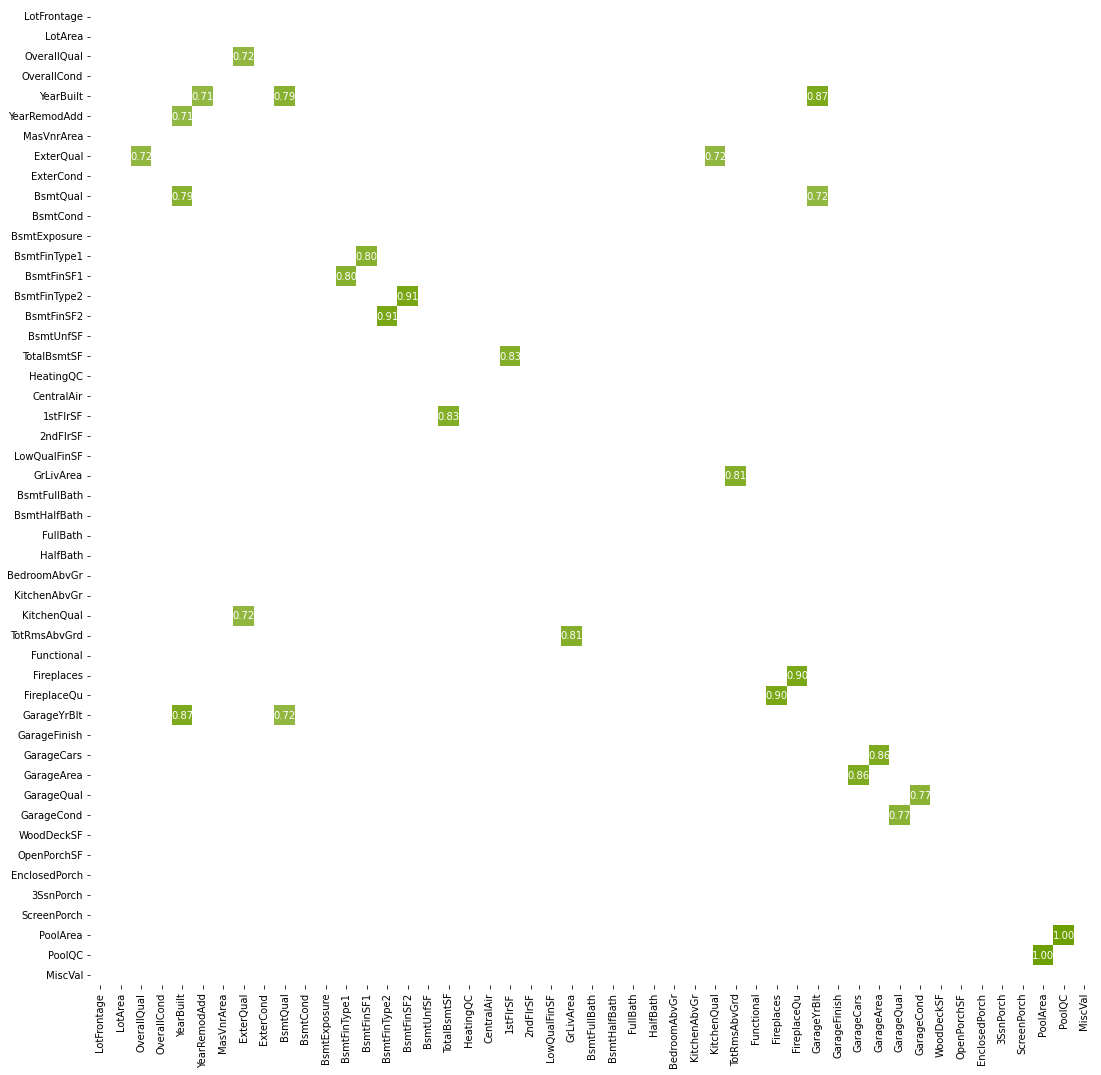

In [12]:
corr = df_num_ord.corr(method='spearman')
kot = corr[((corr>=.7) | (corr<=-0.7)) & (corr!=1.0)]
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(kot,ax=ax,center=0,annot=True,fmt='0.2f',cbar=False,cmap=sns.diverging_palette(110,110,s=100,l=60,center='light',as_cmap=True));
fig.savefig('num_corr.jpeg', dpi=1200, bbox_inches='tight')

We will define a function which will accept the dataset and threshold correlation coefficient as input and will return the list of columns having correlation coefficient with atleast one other column more than the threshold

In [13]:
def correlation(dataset, threshold):
    col_corr = set()
#     row_corr = set()
    # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
#                 rowname = corr_matrix.columns[j]
                col_corr.add(colname)
#                 row_corr.add(rowname)
    return col_corr

In [14]:
corr_features = correlation(df_num_ord, 0.7)
corr_features

{'1stFlrSF',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtQual',
 'ExterQual',
 'FireplaceQu',
 'GarageArea',
 'GarageCond',
 'GarageYrBlt',
 'KitchenQual',
 'PoolQC',
 'TotRmsAbvGrd',
 'YearRemodAdd'}

In [15]:
df_num_ord.drop(corr_features, axis=1, inplace=True, errors='ignore')
df_total.drop(corr_features, axis=1, inplace=True, errors='ignore')

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Skewness of sales price and featureset

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 mu = 180932.92 and sigma = 79467.79



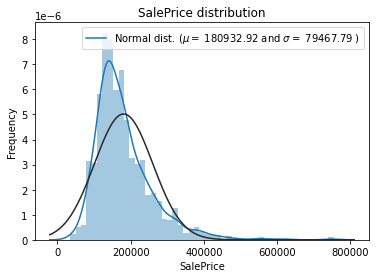

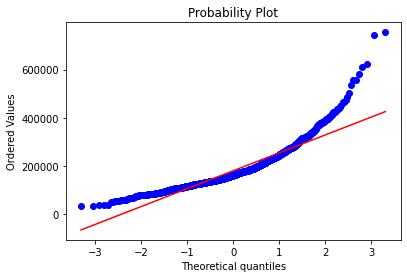

In [16]:
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

The Sales Price distribution is skewed with heavy right tail. Since one of the common assumption of Linear Regression is Normal Distribution of errors (which translates to normal distribution of output variable given input variables and normal distribution of the errors), we will try to transform output variable to Normal Distribution [1]. We will try log1p transform and check the Q-Q plot for normality

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).




 mu = 12.02 and sigma = 0.40



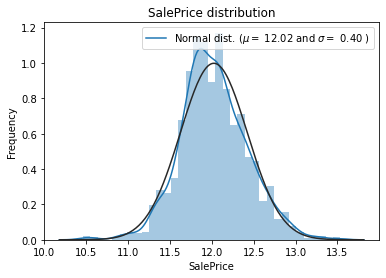

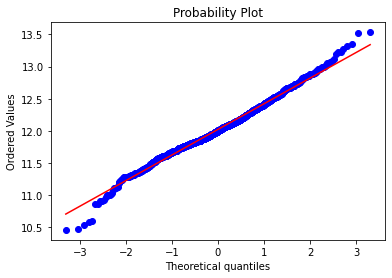

In [17]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

#Check the new distribution 
sns.distplot(df_train['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)
plt.show()

Applying log transform made the sales price near normally distributed.

### One hot encoding

Finally we need to perform one hot encoding of the categorical variable. To avoid multicollinearity among the input variables we will drop the first column of every one hot encoded variable. 

In [18]:
df_total = pd.get_dummies(df_total,drop_first=True)

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

### Preparing training and testing data

In [20]:
#records and features in the training dataset
n_train = df_train.index[-1] 

X=df_total.loc[:n_train]
y=df_train['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

### Plain Linear Regression

In [21]:
LR = LinearRegression()
LR.fit(X_train, y_train)
y_pred=LR.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test-y_pred)**2))
#ysub_pred = np.expm1(LR.predict(df_total.loc[n_train+1:]))
#submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
#submission.to_csv('LR_final.csv')
r2, rmse

(0.9139652103513323, 0.10997865323784144)

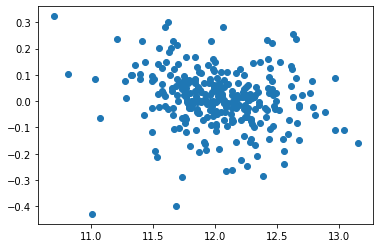

In [22]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

Residual vs output variable plot determines the extent of homoscedasticity of the residuals. The above plot shows that residuals are not perfectly homoscedastic although the range of residual variance is quite narrow. We will explore other regression models as well and check its homoscedasticity. 

### Random Forest Regression

In [23]:
RF = RandomForestRegressor(n_estimators=100, max_depth=12)
RF.fit(X_train, y_train)
y_pred=RF.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test-y_pred)**2))
ysub_pred = np.expm1(RF.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('RF_final.csv')
r2, rmse
r2, rmse

(0.8727090463598146, 0.13377350821976844)

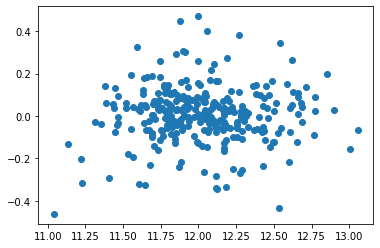

In [24]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

### Ridge Regression

In [25]:
Rdge = Ridge(alpha=10)
Rdge.fit(X_train, y_train)
y_pred=Rdge.predict(X_test)

ysub_pred = np.expm1(Rdge.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('Rdge_final.csv')
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2, rmse

(0.926870872061736, 0.10139500099182659)

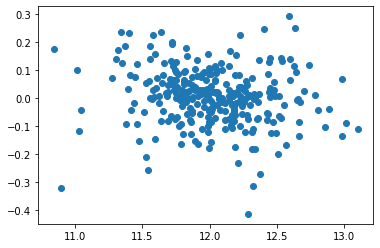

In [26]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

### Lasso Regression

In [27]:
Lsso = Lasso(alpha=0.5)
Lsso.fit(X_train, y_train)
y_pred=Lsso.predict(X_test)

ysub_pred = np.expm1(Lsso.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('Lsso_final.csv')
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2, rmse

(0.8003031725055141, 0.16755482142886988)

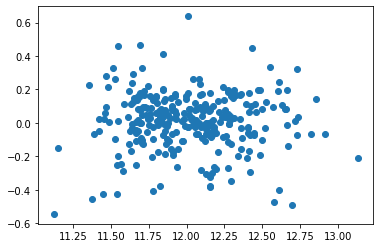

In [28]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

### Elasic Net Regression

In [29]:
EN = ElasticNet(alpha=5, l1_ratio=0.05)
EN.fit(X_train, y_train)
y_pred=EN.predict(X_test)

ysub_pred = np.expm1(EN.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('Lsso_final.csv')
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))
r2, rmse

(0.8064565233908223, 0.1649531508160645)

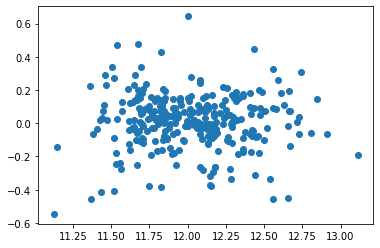

In [30]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

<span style="font-size:20px;"> 
    Let us use cross validation, and grid search to find best parameters for ridge, lasso, elasticnet
</span>

In [31]:
from sklearn.model_selection import GridSearchCV

In [32]:
parameters = {'alpha' : [13]}
scoring = ['neg_mean_squared_error', 'r2']
ridgeCV = GridSearchCV(Ridge(), param_grid=parameters, scoring=scoring, refit='r2', cv=5).fit(X, y)
print(f"Best Ridge Regressor is {ridgeCV.best_estimator_} and corresponding r2 score on prediction is {ridgeCV.best_score_}")

ysub_pred_ridgeCV = np.expm1(ridgeCV.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred_ridgeCV,index=df_test.index,columns=['SalePrice'])
submission.to_csv('ridgeCV_final.csv')

Best Ridge Regressor is Ridge(alpha=13) and corresponding r2 score on prediction is 0.9183709271204279


In [33]:
parameters = {'alpha' : [5e-4]}
scoring = ['neg_mean_squared_error', 'r2']
lassoCV = GridSearchCV(Lasso(), param_grid=parameters, scoring=scoring, refit='r2', cv=5).fit(X, y)
print(f"Best Lasso Regressor is {lassoCV.best_estimator_},  and corresponding r2 score on prediction is {lassoCV.best_score_}")

ysub_pred_lassoCV = np.expm1(lassoCV.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred_lassoCV,index=df_test.index,columns=['SalePrice'])
submission.to_csv('lassoCV_final.csv')

Best Lasso Regressor is Lasso(alpha=0.0005),  and corresponding r2 score on prediction is 0.9194014123565719


<span style="font-size:20px;"> 
    Since we know the approximate range of parameters for ridge and lasso that yields best r2 score on the test data. Let us use it to find best combination of parameters that can be used in ElasticNet
</span>

In [34]:
parameters = {'alpha' : [0.05], 'l1_ratio' : [1e-5]}
scoring = ['neg_mean_squared_error', 'r2']
enetCV = GridSearchCV(ElasticNet(), param_grid=parameters, scoring=scoring, refit='r2', cv=5).fit(X, y)
print(f"Best ElasticNet Regressor is {enetCV.best_estimator_}, and corresponding r2 score on prediction is {enetCV.best_score_}")

ysub_pred_enetCV = np.expm1(enetCV.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('enetCV_final.csv')

Best ElasticNet Regressor is ElasticNet(alpha=0.05, l1_ratio=1e-05), and corresponding r2 score on prediction is 0.9159630630666442


## Stacking the best regressors

In [35]:
estimators = [('ridgeCV', ridgeCV), ('lassoCV', lassoCV)]
stackCV = StackingRegressor(estimators=estimators, final_estimator=lassoCV)
stackCV.fit(X_train, y_train)
y_pred=stackCV.predict(X_test)

ysub_pred = np.expm1(stackCV.predict(df_total.loc[n_train+1:]))
submission = pd.DataFrame(data=ysub_pred,index=df_test.index,columns=['SalePrice'])
submission.to_csv('stackCV_final.csv')
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))

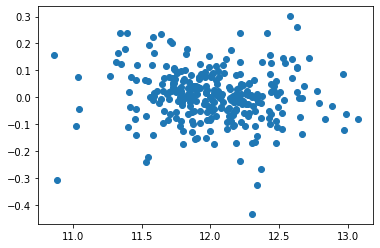

In [36]:
residual = y_test - y_pred
plt.scatter(y_pred, residual)
plt.show()

### Gradient Boosting

In [37]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [38]:
XGB = XGBRegressor(n_estimators=600,
                   learning_rate=0.05,
                   max_depth=4,
                   booster='dart',
                   objective='reg:squarederror'
                  )


XGB.fit(X_train, y_train)
        #early_stopping_rounds=20,
        #eval_metric = 'rmse',
        #verbose=2,
        #eval_set = [(X_test, y_test)]

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=600, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [39]:
ysub_pred_XGB = np.exp(XGB.predict(df_total.loc[n_train+1:]))-1
submission = pd.DataFrame(data=ysub_pred_XGB, index=df_test.index, columns=['SalePrice'])
submission.to_csv('XGB_final.csv')

In [40]:
ysub_pred_avg = 0.4*ysub_pred_ridgeCV + 0.6*ysub_pred_XGB
submission = pd.DataFrame(data=ysub_pred_avg, index=df_test.index, columns=['SalePrice'])
submission.to_csv('Average_final.csv')

In [41]:
LGBM =LGBMRegressor(n_estimators=1000,
                   learning_rate=0.05,
                   max_depth=4,
                    gamma=0.1,
                    reg_lambda=1,
                   objective='regression').fit(X, y)


ysub_pred = np.exp(LGBM.predict(df_total.loc[n_train+1:]))-1
submission = pd.DataFrame(data=ysub_pred, index=df_test.index, columns=['SalePrice'])
submission.to_csv('LGBM_final.csv')

[LightGBM] [Warning] Unknown parameter: gamma
